In [0]:
import argparse
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np 
import os
from os.path import join
import pandas as pd
import pickle 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys
plt.rcParams.update({'font.size': 22})
from pathlib import Path

In [0]:
# n is the number of hidden units in the RBM
# k is the number of steps of contrastive divergence to run per example
n = 100
k = 1
eta = 7e-4 
num_epochs = 7
path_train = Path('/content/train.csv')
path_test = Path('/content/test.csv')

Implementing some functions

In [0]:
# The function sample_vector first calculates the probability of a pixel taking a particular value(0 or 1 in our case). So, totally 784 values of probability will be calculated 
# because our images are (28x28) images, that's 784 pixel values. 

# Next we pick a random value between 0 to 1 from a continous uniform distribution. If the random value < its corresponding calculated probability, make that pixel 1, otherwise 
# make the pixel zero. 

# So, the function sample_vector samples a new value of every random variable(pixels) in each time step. This is nothing but generating a new image in every time step. 

def sigmoid(z):
	return 1/(1 + np.exp(-z))

def sample_vector(n, weight, vector, bias):
	if vector.ndim == 1:
		vector = vector[:, np.newaxis]
	if bias.ndim == 1:
		bias = bias[:, np.newaxis]

	z_linear = np.dot(weight, vector) + bias
	probs = sigmoid(z_linear)
	if probs.ndim == 1:
		probs = probs[:, np.newaxis]
 
	assert np.shape(probs) == (n,1) 
	random = np.random.random((n,1))
	one = random < probs
	zerovec = np.zeros((n,1))
	zerovec[one] = 1
	assert zerovec.ndim == 2
	return zerovec

Setting values

In [0]:
threshold = 127
path_folder = "./k" + str(k) + " n" + str(n) + " eta" + str(eta) + " epochs" + str(num_epochs)
try:
	os.mkdir(path_folder)
except FileExistsError:
    print("folder already exists. Name: " + path_folder)


Preparing the data

In [5]:
data_train_df = pd.read_csv(path_train)
data_train = data_train_df.to_numpy()
X_train = data_train[:,1:-1]
print(f'X_train shape = {X_train.shape}')
labels_train = data_train[:,-1]

data_test_df = pd.read_csv(path_test)
data_test = data_test_df.to_numpy()
X_test = data_test[:,1:-1]
print(f'X_test shape = {X_test.shape}')
labels_test = data_test[:,-1]

X_train shape = (60000, 784)
X_test shape = (10000, 784)


Thesholding

In [6]:
greater = X_train >= threshold
lesser = X_train < threshold

X_train_thresh = X_train.copy()
X_train_thresh[greater] = 1
X_train_thresh[lesser] = 0
print(f'Shape of X_train_thresh = {X_train_thresh.shape}')

greater = X_test >= threshold
lesser = X_test < threshold

X_test_thresh = X_test.copy()
X_test_thresh[greater] = 1
X_test_thresh[lesser] = 0

print("max", np.max(X_test_thresh), np.max(X_train_thresh))

Shape of X_train_thresh = (60000, 784)
max 1 1


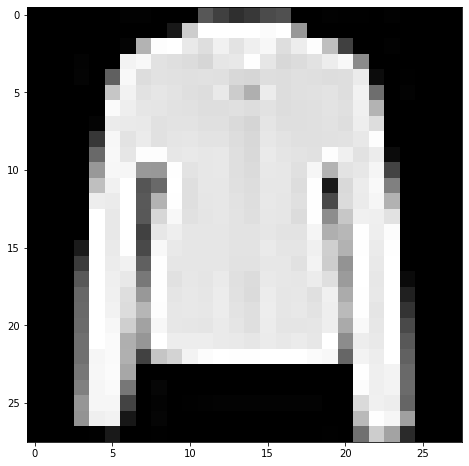

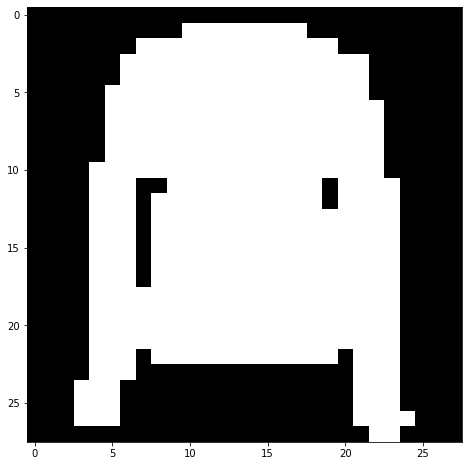

In [7]:
image_id = 1032
image = np.reshape(X_train[image_id,:], (28,28))
image_thresh = np.reshape(X_train_thresh[image_id, :], (28,28))

plt.figure(figsize = (10,8))
plt.imshow(image, cmap = "gray")
plt.show()
plt.close()

plt.figure(figsize = (10,8))
plt.imshow(image_thresh, cmap = "gray")
plt.show()
plt.close()


Training RBM

In [8]:
num_visible = np.shape(X_train_thresh)[1]
print(num_visible)

W = 0.01*np.random.randn(n, num_visible)
# print(np.shape(W))
b = np.zeros((num_visible,1))
c = np.zeros((n,1))


784


number of examples:  60000
Epoch:  0


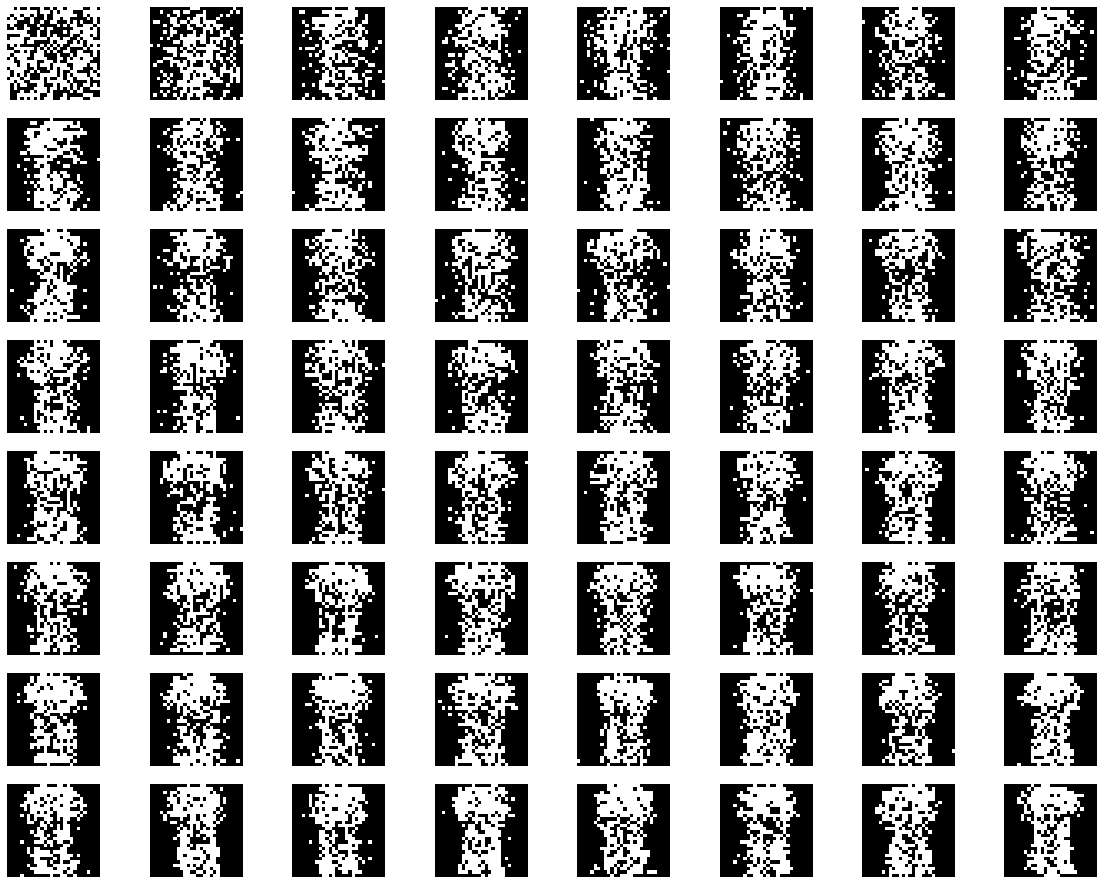

Epoch:  1


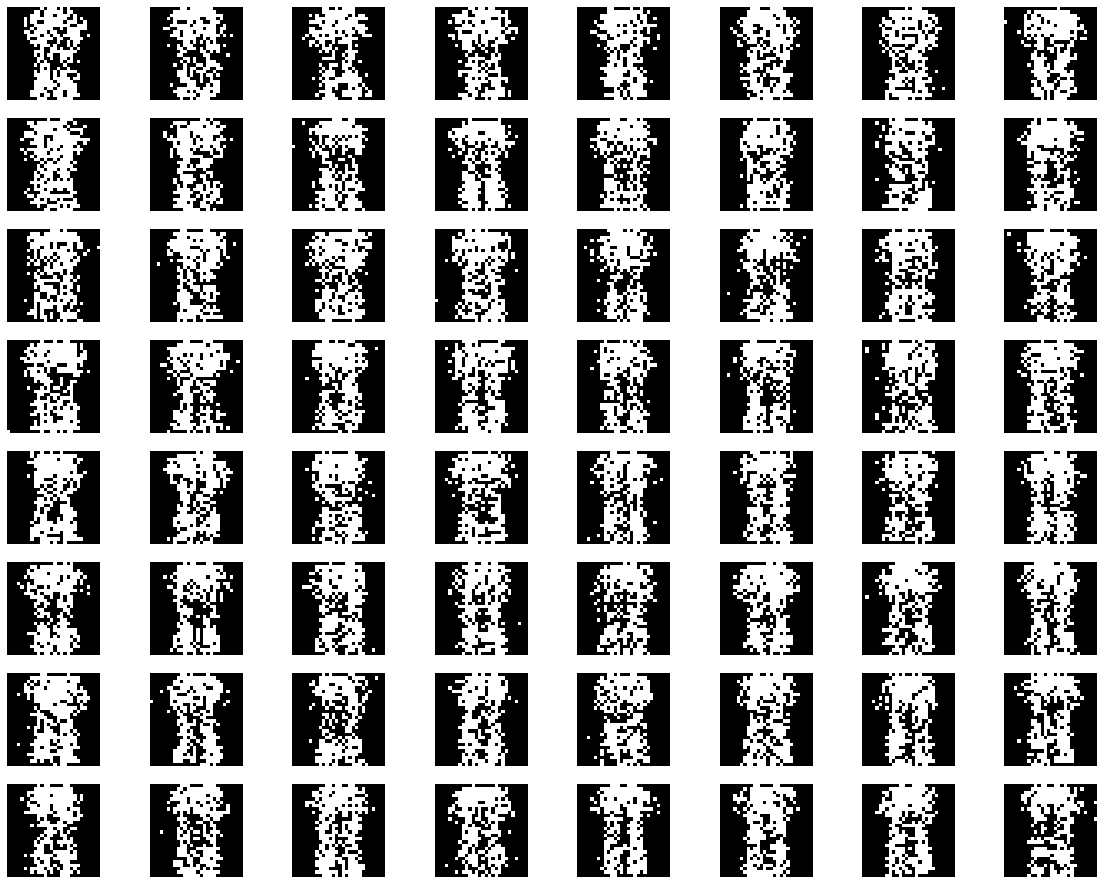

Epoch:  2


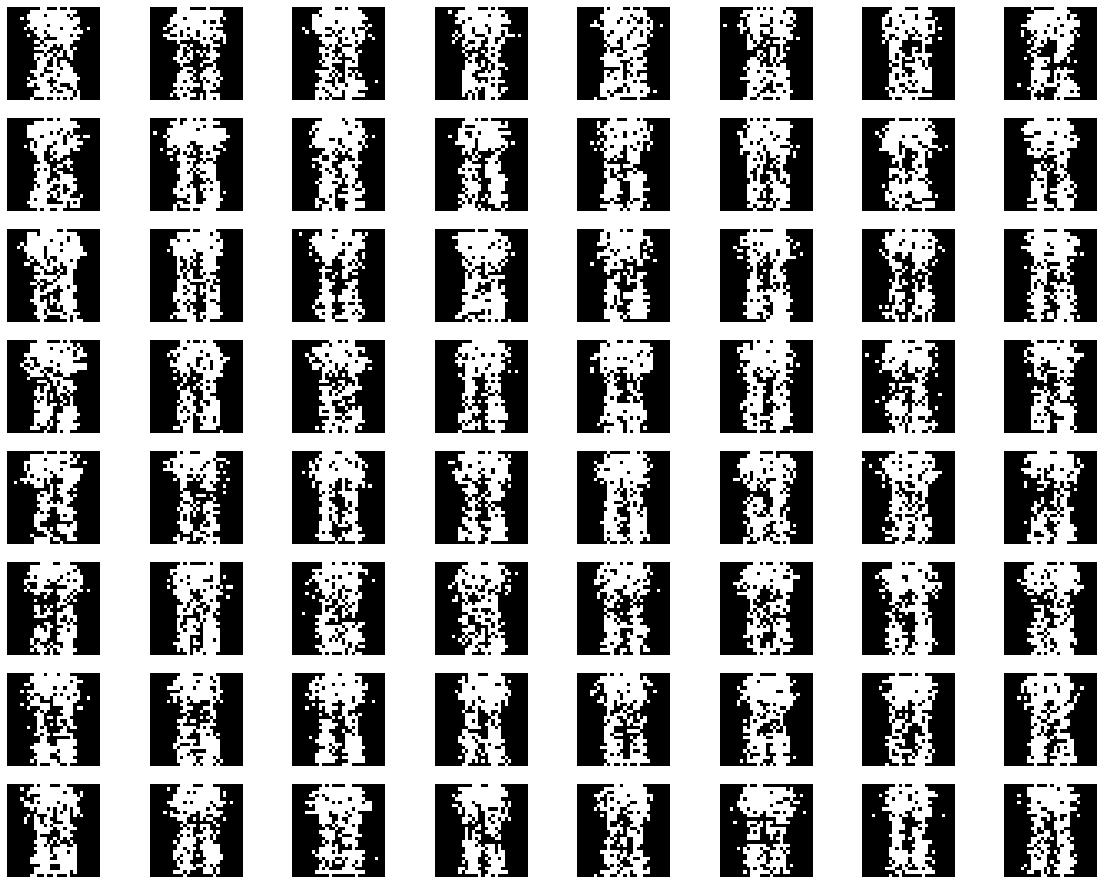

Epoch:  3


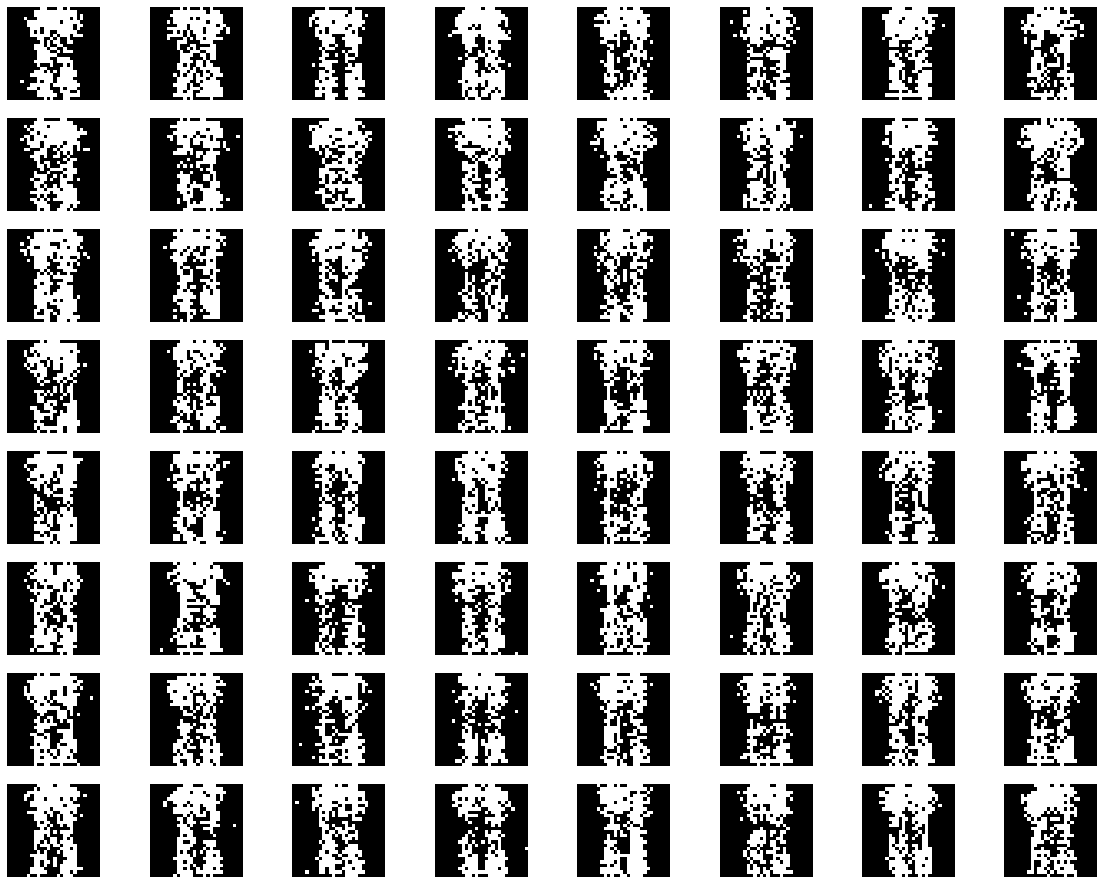

Epoch:  4


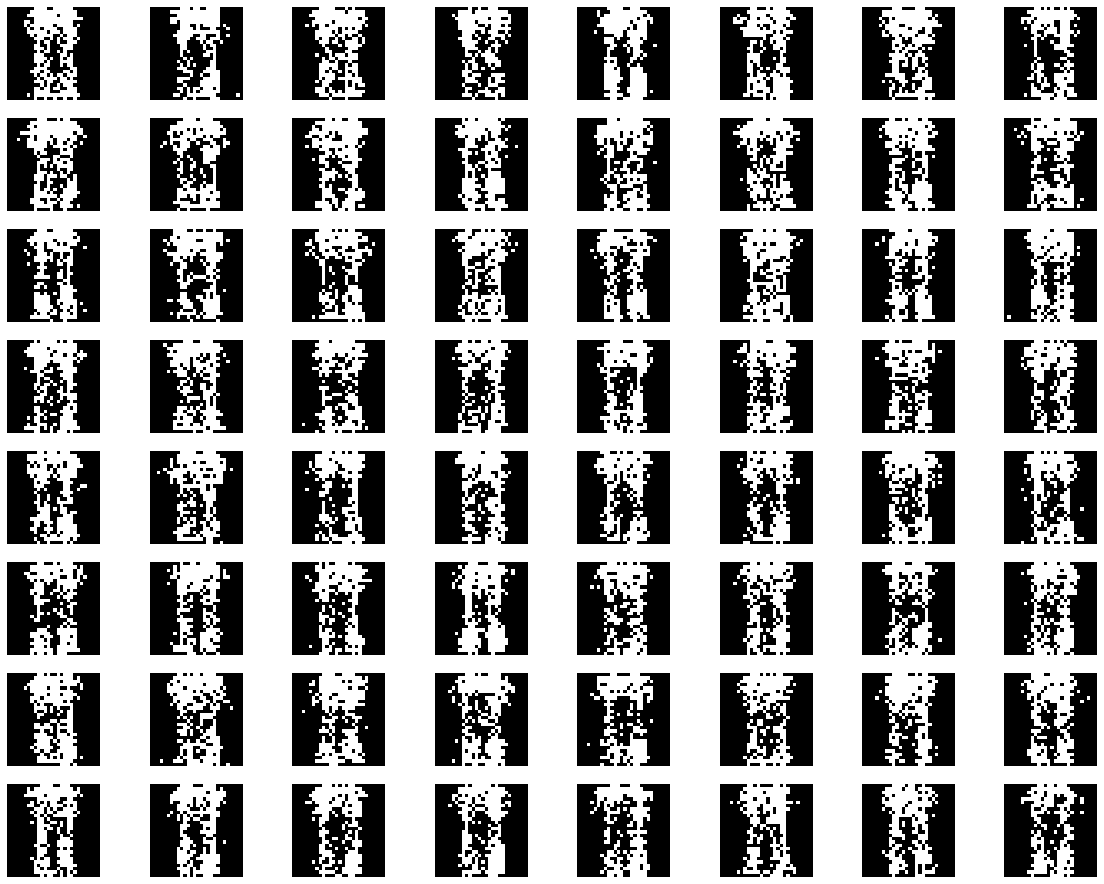

Epoch:  5


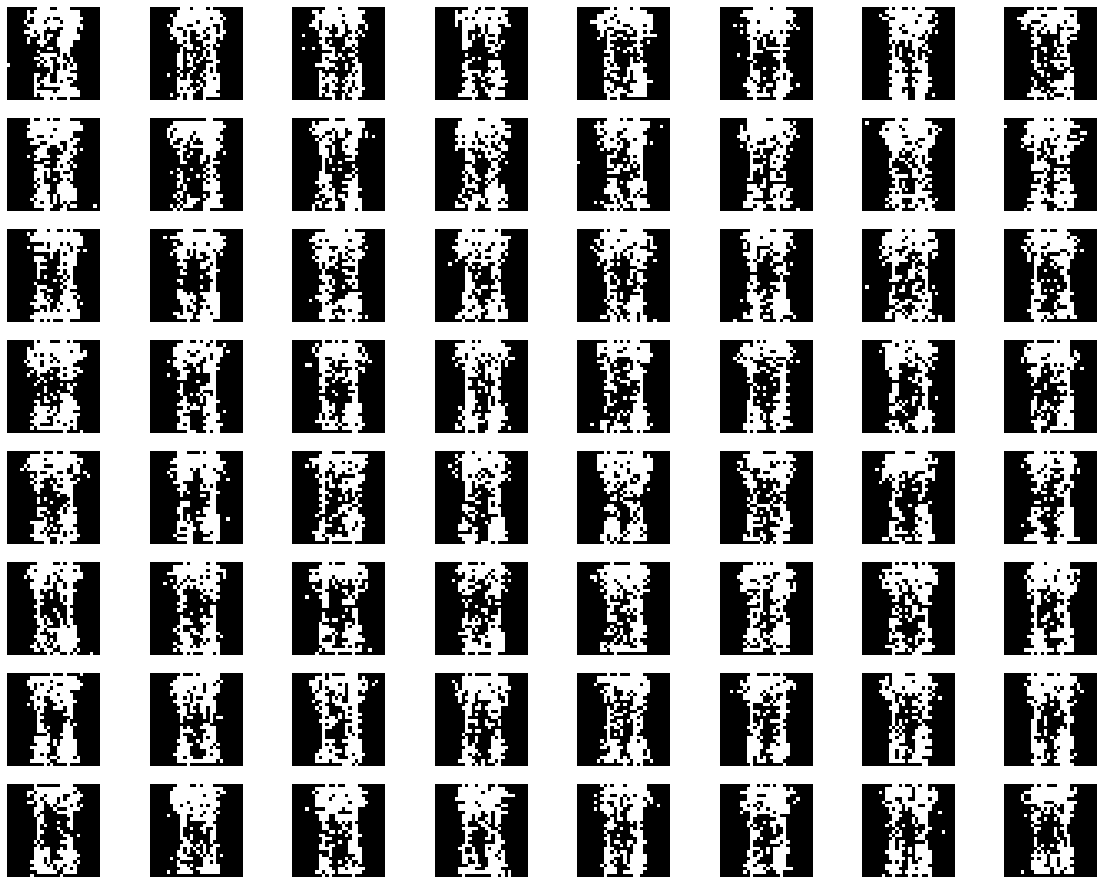

Epoch:  6


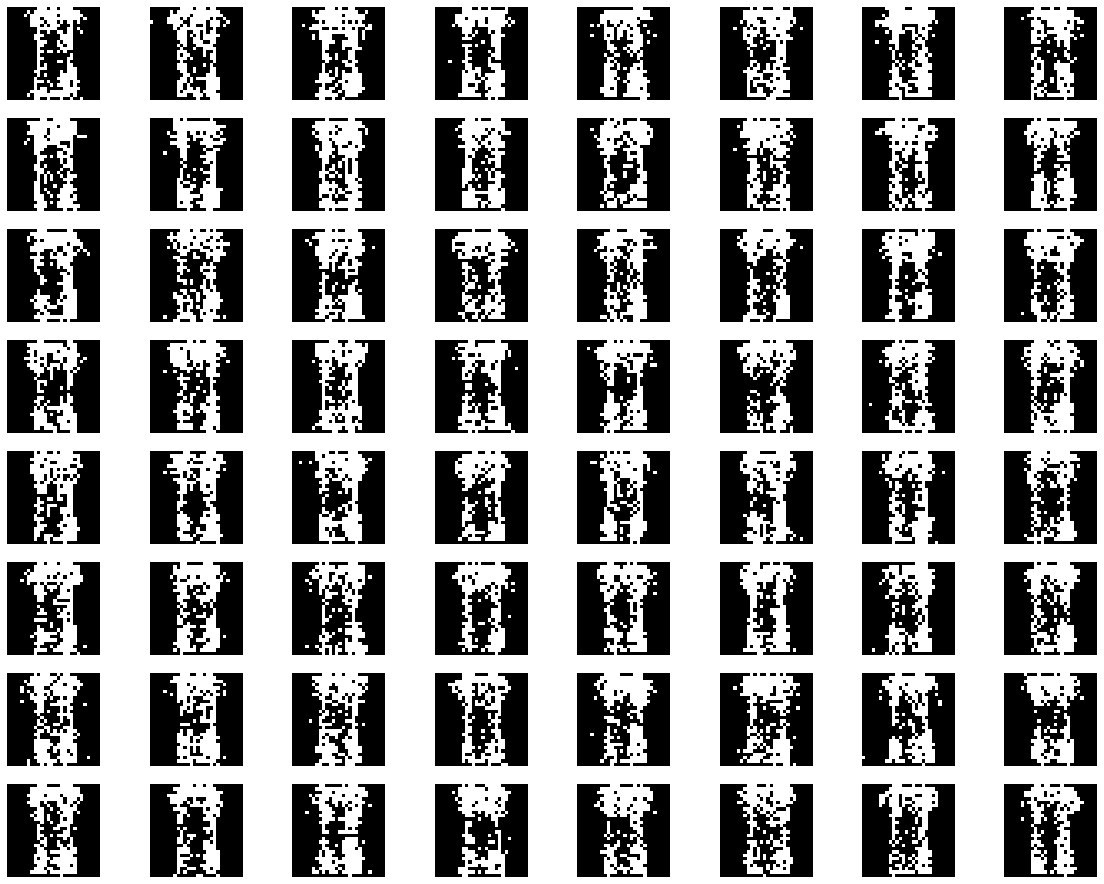

In [9]:
num_examples = np.shape(X_train_thresh)[0]
print("number of examples: ", num_examples)
h = np.zeros((n,1))
image_id = 3
image_thresh = np.reshape(X_train_thresh[image_id, :], (28,28))

plt.figure(figsize = (10,8))
plt.imshow(image_thresh, cmap = "gray")
plt.savefig(join(path_folder, "original.png"))
plt.close()

image_temp = X_train_thresh[image_id,:]

for epoch in range(num_epochs):
	print("Epoch: ", epoch)
	plt.figure(figsize = (20,16))
	subplot_no = 1
	for i in range(num_examples):
		if ((i%(936) == 0)) and (subplot_no <= 64):
			h_temp =  sample_vector(n, W, image_temp, c)
			image_recon_temp1 = sample_vector(num_visible, W.T, h_temp, b)
			image_recon_temp = np.reshape(image_recon_temp1, (28,28))
			plt.subplot(8,8,subplot_no)
			plt.imshow(image_recon_temp, cmap = "gray")
			plt.axis("off")
			subplot_no += 1

		v = X_train_thresh[i,:]
		if v.ndim == 1:
			v = v[:, np.newaxis]
		vtemp = X_train_thresh[i,:]
		if vtemp.ndim == 1:
			vtemp = vtemp[:, np.newaxis]

    #  Gibbs sampling step
		for t in range(k):
			h = sample_vector(n, W, vtemp, c)
			vtemp = sample_vector(num_visible, W.T, h, b)

		z = sigmoid(np.dot(W,v) + c)
		if z.ndim == 1:
			z = z[:, np.newaxis]
		ztemp = sigmoid(np.dot(W, vtemp) + c)
		if ztemp.ndim == 1:
			ztemp = ztemp[:, np.newaxis]

		W = W + eta*(np.dot(z, v.T) - np.dot(ztemp, vtemp.T))
		b = b + eta*(v - vtemp)
		c = c + eta*(z - ztemp)

	plt.savefig(join(path_folder,"changing_image"+ str(epoch) + ".png"))
	plt.show()
	plt.close()


number of examples:  60000
Epoch:  0


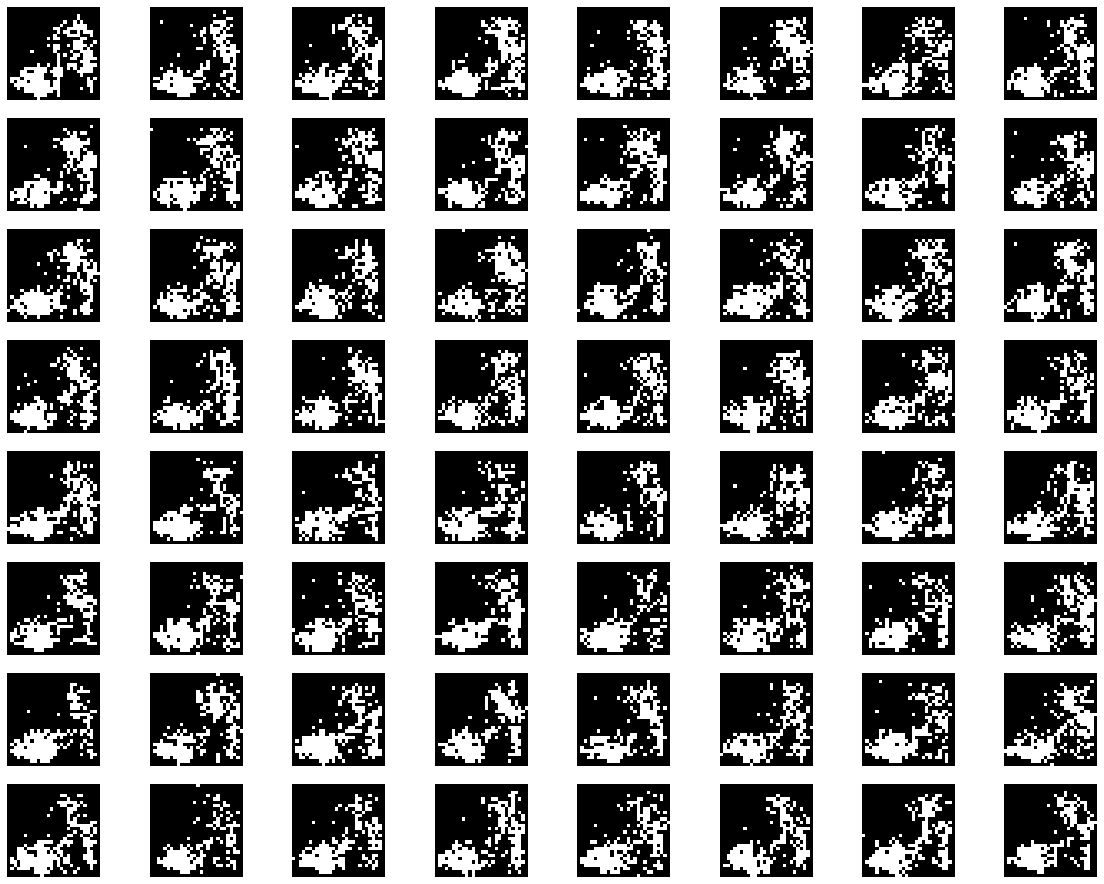

Epoch:  1


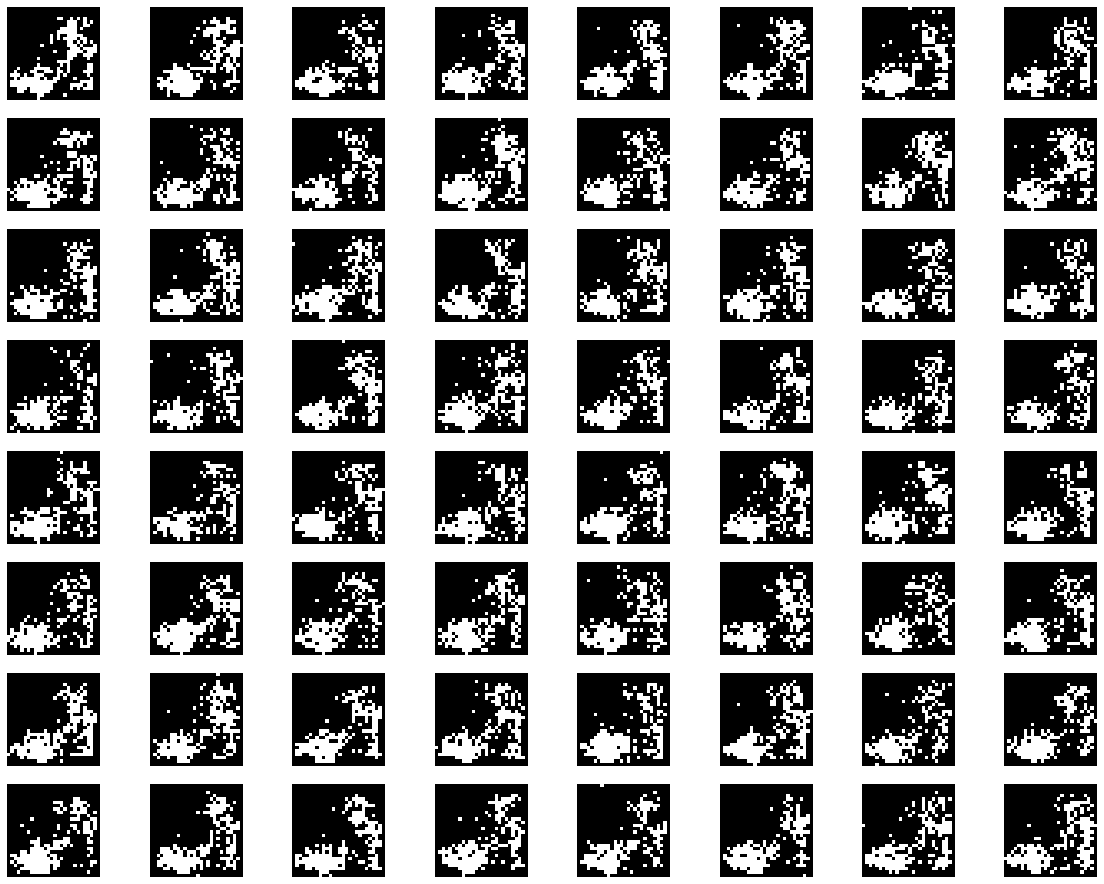

Epoch:  2


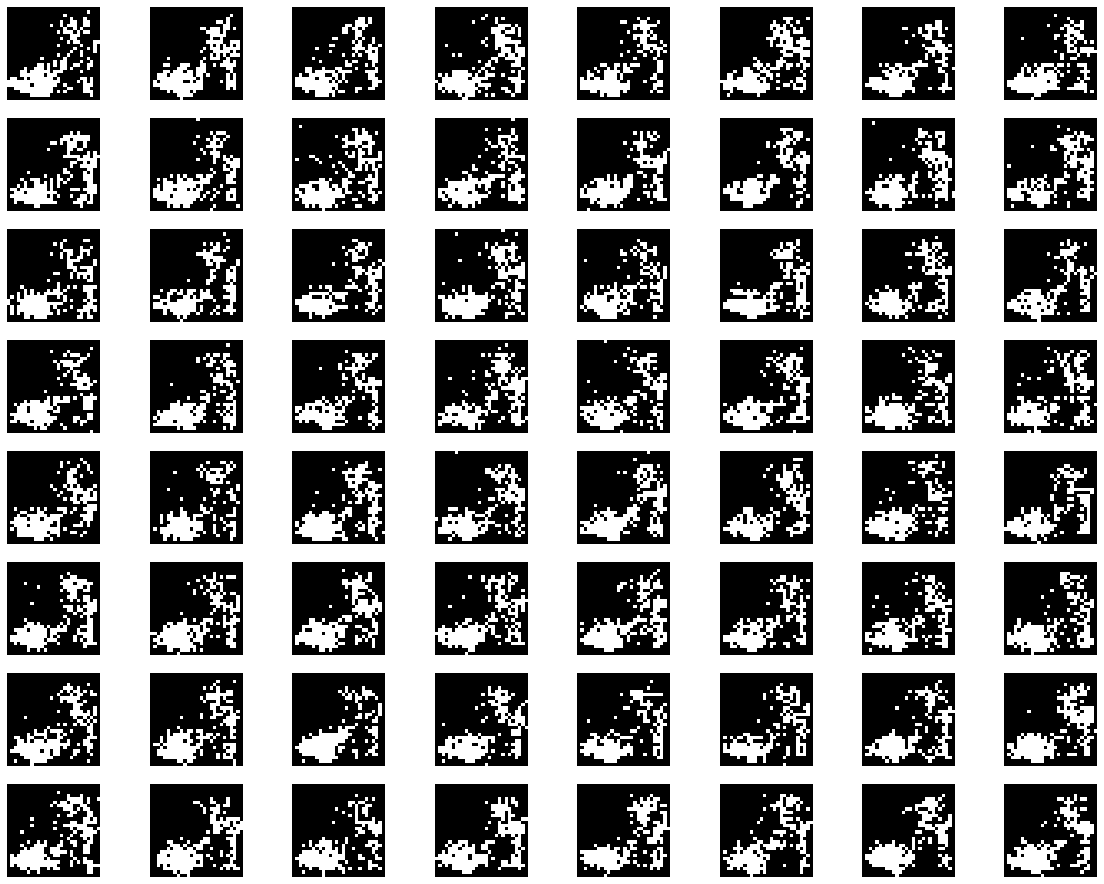

Epoch:  3


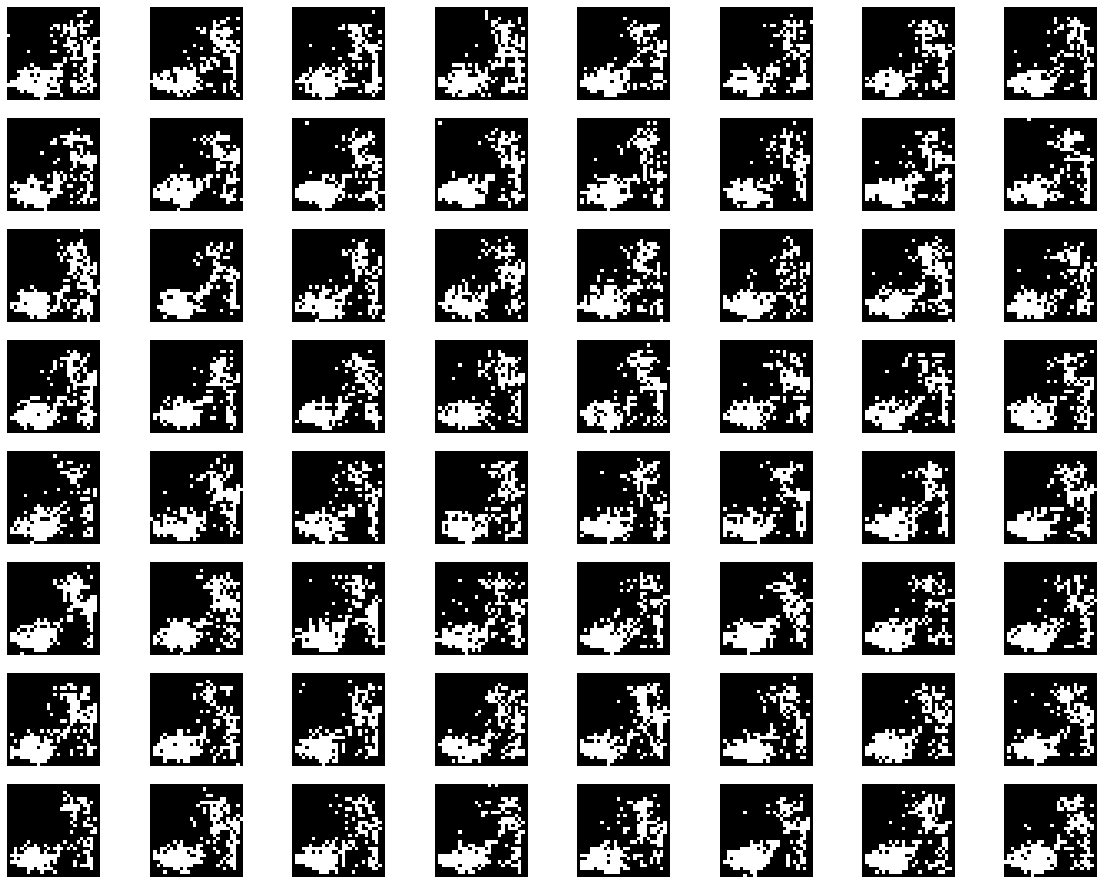

Epoch:  4


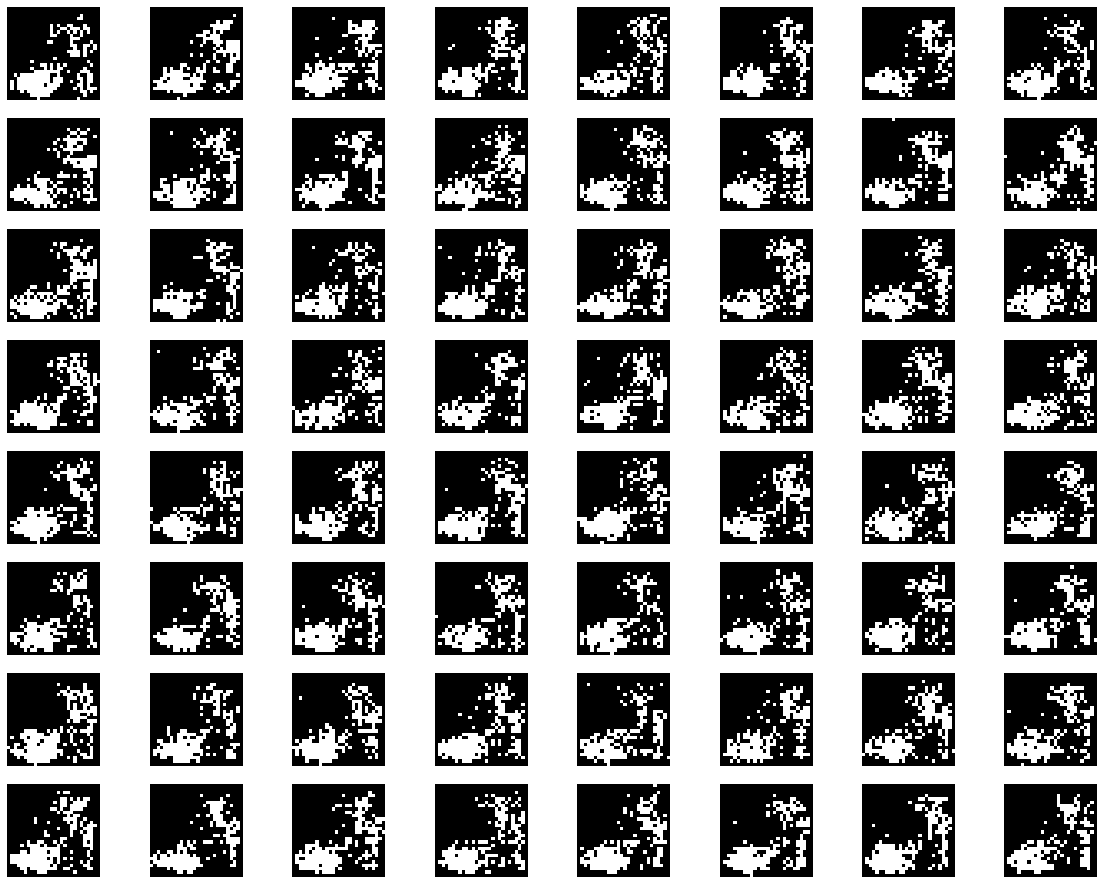

Epoch:  5


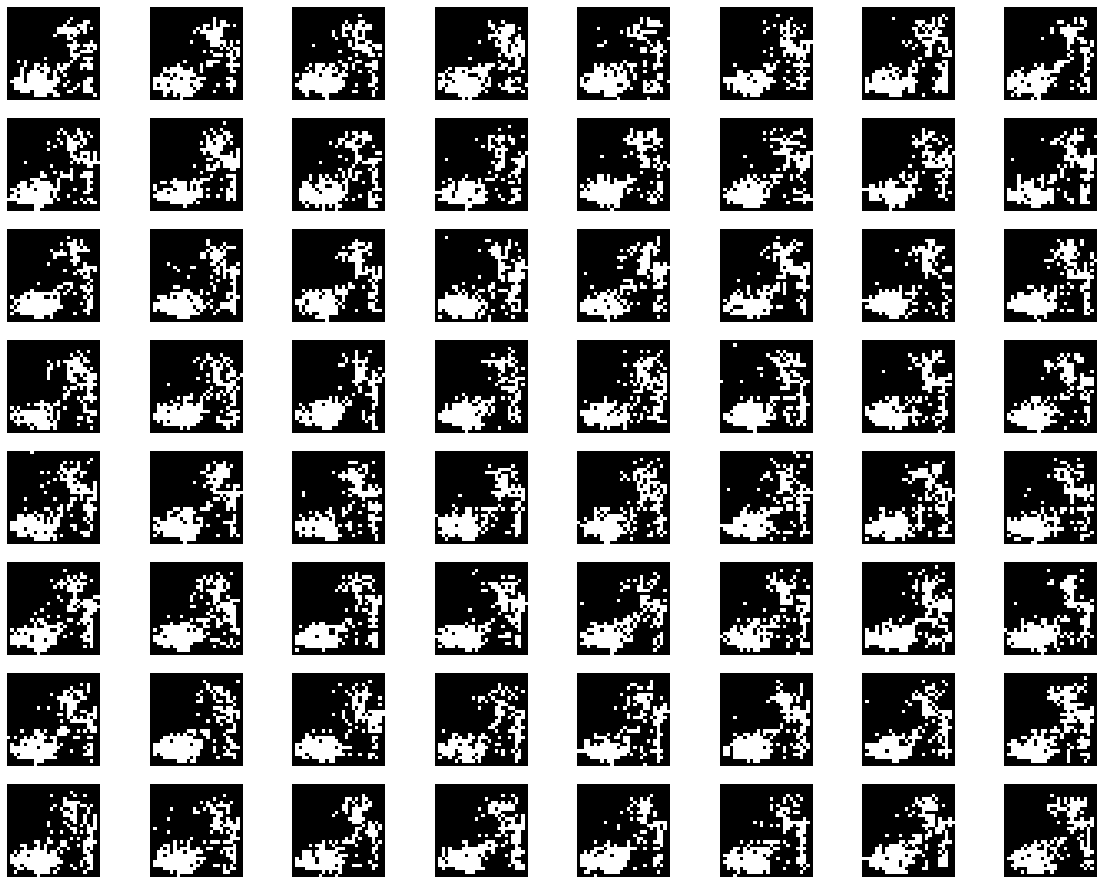

Epoch:  6


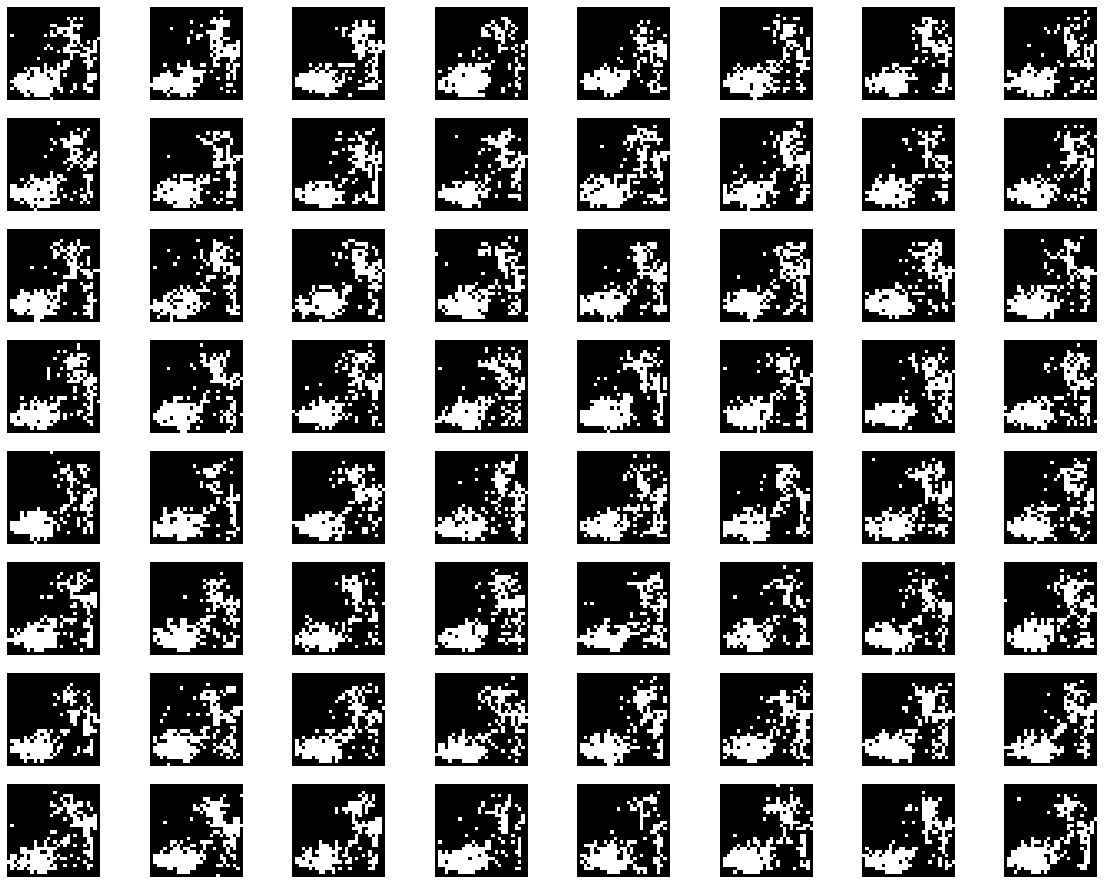

In [10]:
num_examples = np.shape(X_train_thresh)[0]
print("number of examples: ", num_examples)
h = np.zeros((n,1))
image_id = 9
image_thresh = np.reshape(X_train_thresh[image_id, :], (28,28))

plt.figure(figsize = (10,8))
plt.imshow(image_thresh, cmap = "gray")
plt.savefig(join(path_folder, "original.png"))
plt.close()

image_temp = X_train_thresh[image_id,:]

for epoch in range(num_epochs):
	print("Epoch: ", epoch)
	plt.figure(figsize = (20,16))
	subplot_no = 1
	for i in range(num_examples):
		if ((i%(936) == 0)) and (subplot_no <= 64):
			h_temp =  sample_vector(n, W, image_temp, c)
			image_recon_temp1 = sample_vector(num_visible, W.T, h_temp, b)
			image_recon_temp = np.reshape(image_recon_temp1, (28,28))
			plt.subplot(8,8,subplot_no)
			plt.imshow(image_recon_temp, cmap = "gray")
			plt.axis("off")
			subplot_no += 1

		v = X_train_thresh[i,:]
		if v.ndim == 1:
			v = v[:, np.newaxis]
		vtemp = X_train_thresh[i,:]
		if vtemp.ndim == 1:
			vtemp = vtemp[:, np.newaxis]

    #  Gibbs sampling step
		for t in range(k):
			h = sample_vector(n, W, vtemp, c)
			vtemp = sample_vector(num_visible, W.T, h, b)

		z = sigmoid(np.dot(W,v) + c)
		if z.ndim == 1:
			z = z[:, np.newaxis]
		ztemp = sigmoid(np.dot(W, vtemp) + c)
		if ztemp.ndim == 1:
			ztemp = ztemp[:, np.newaxis]

		W = W + eta*(np.dot(z, v.T) - np.dot(ztemp, vtemp.T))
		b = b + eta*(v - vtemp)
		c = c + eta*(z - ztemp)

	plt.savefig(join(path_folder,"changing_image"+ str(epoch) + ".png"))
	plt.show()
	plt.close()

(784, 1)


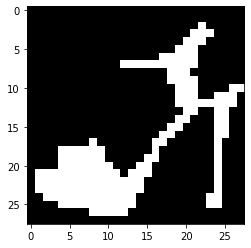

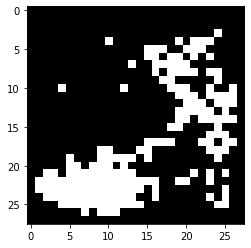

In [11]:
image = X_train_thresh[image_id,:]
h = sample_vector(n, W, image, c)
vtemp = sample_vector(num_visible, W.T, h, b)
print(np.shape(vtemp))

image = np.reshape(image, (28,28))
vtemp = np.reshape(vtemp, (28,28))

plt.figure()
plt.imshow(image, cmap = "gray")
plt.savefig(join(path_folder, "origafter.png"))
plt.show()
plt.close()

plt.figure()
plt.imshow(vtemp, cmap = "gray")
plt.savefig(join(path_folder, "origarecon.png"))
plt.show()
plt.close()


Computing the hidden representations for the test images using TSNE

Computing the hidden representations for the training examples
Shape of test data:  (10000, 784)
(10000, 100)
(10000, 2)
(10000,)


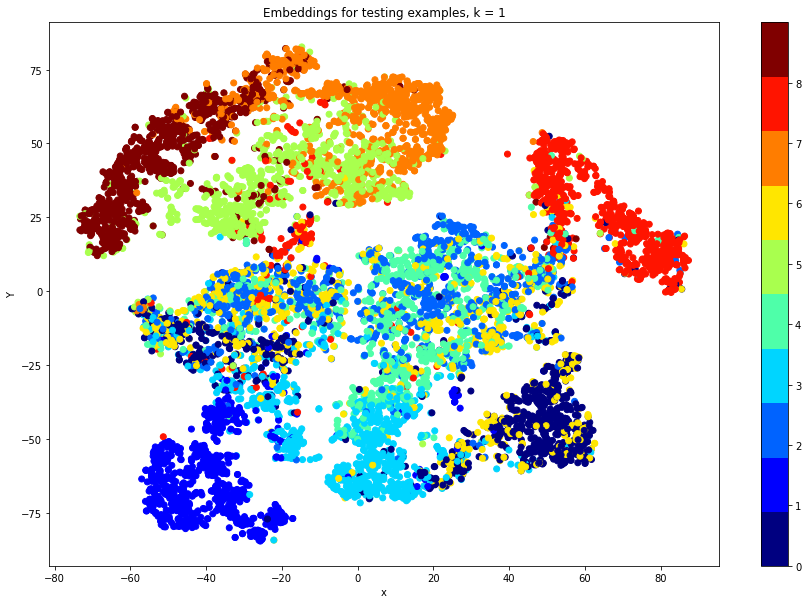

In [12]:
print("Computing the hidden representations for the training examples")
print("Shape of test data: ", np.shape(X_test_thresh))

num_test_examples = np.shape(X_test_thresh)[0]
hidden_reps = []
for i in range(num_test_examples):
	image = X_test_thresh[i,:]
	h = sample_vector(n, W, image, c)
	hidden_reps.append(np.array(h[:,0]))

print(np.shape(hidden_reps))

hidden_reps = np.array(hidden_reps)

embedded = TSNE(n_components = 2, early_exaggeration = 7).fit_transform(hidden_reps)
print(np.shape(embedded))

# path_pickle = join(path_folder, "embedded.pickle")

vis_x = embedded[:,0]
vis_y = embedded[:,1]

print(np.shape(labels_test))

plt.figure(figsize = (15,10))
plt.title("Embeddings for testing examples, k = " + str(k))
plt.xlabel("x")
plt.ylabel("Y")
plt.scatter(vis_x[:10000], vis_y[:10000], c = labels_test[:10000], cmap = plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks = range(max(labels_test)))
plt.savefig(join(path_folder, "clusters_test.png"))
plt.show()
plt.close()

Computing the hidden representations for the test images using UMAP

(10000, 2)


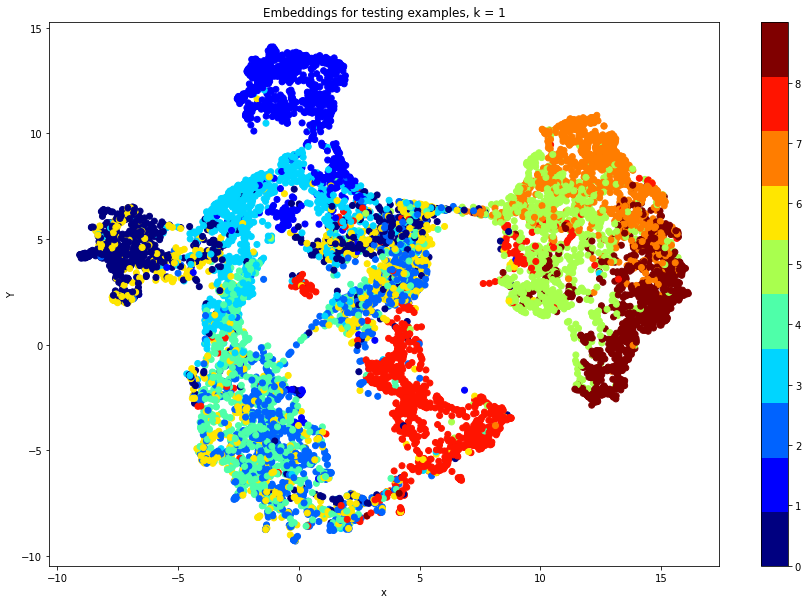

In [13]:
import umap
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(hidden_reps)
print(np.shape(embedding))

vis_x = embedding[:,0]
vis_y = embedding[:,1]

plt.figure(figsize = (15,10))
plt.title("Embeddings for testing examples, k = " + str(k))
plt.xlabel("x")
plt.ylabel("Y")
plt.scatter(vis_x[:10000], vis_y[:10000], c = labels_test[:10000], cmap = plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks = range(max(labels_test)))
plt.savefig(join(path_folder, "clusters_test_umap.png"))
plt.show()
plt.close()